In [274]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.fft import fft, ifft, fftfreq
from matplotlib.pyplot import figure

In [275]:
NUM_PORTS = 4
SIZE = 200
imp0 = 377
connect = 50
tau = 0.3
kappa = 0.5 # not working yet for complex numnber


maxTime = 2000

N_seg = 6

sources = [[-1,-1],[0,2],[3,5],[2,0],[5,3],[2,4]]
couplings = [[tau,kappa],[tau,kappa],[tau,kappa],[tau,kappa],[tau,kappa],[tau,kappa]]

ez_tab = np.zeros([N_seg, maxTime, SIZE])

In [287]:
def gaussian(qTime):
    return np.exp(-(qTime - 30.) * (qTime - 30.) / 100.) /imp0

def cw(Time):
    return np.exp(-(Time - 30.) * (Time - 30.) / 100000000.) /imp0

def cosMod(qTime):
    dt = 10e-17  # Time step (s) //added
    t = qTime * dt
    A = 1
    f0 = 300e12
    t0 = 4 * dt * maxTime / 50  # Center time
    tau = 2 * dt * maxTime / 50 # Width
    source = A * np.cos(2 * np.pi * f0 * (t - t0)) * np.exp(-((t - t0)**2) / (tau**2))
    return source

In [297]:
# #Test Source - not needed for the actual program
# N_time = 2000
# dt = 10e-17  # Time step (s)
# t = np.arange(N_time) * dt
# xf = fftfreq(N_time,dt)

# # Pulse parameters
# A = 1.0
# f0 = 200e12       # 200 THz
# t0 = 12 * dt * N_time / 50  # Center time
# tau = 6 * dt * N_time / 50 # Width

# # Define source
# source = A * np.cos(2 * np.pi * f0 * (t - t0)) * np.exp(-((t - t0)**2) / (tau**2))

# # Plot
# figure(figsize=(30,30))
# plt.subplot(2,1,1)
# plt.plot(t * 1e15, source)
# plt.xlabel("Time (fs)")
# plt.ylabel("Amplitude")
# plt.title("Cosine-modulated Gaussian Pulse")
# plt.grid(True)|
# plt.subplot(2,1,2)
# plt.plot(xf, fft(source))
# plt.show()

In [289]:
class segment:
    def __init__(self, SIZE):
        self.ez = np.zeros([SIZE])
        self.hy = np.zeros([SIZE])
        self.sx = 49
        # self.source = source
        # self.tau = coupling[0]
        # self.kappa = coupling[1]
        
    def hy_update(self):
        self.hy[SIZE-1] = self.hy[SIZE-2] # simple ABC for hy
        for j in range(SIZE-1):
            self.hy[j] = self.hy[j] + (self.ez[j+1] - self.ez[j]) / imp0;
            
    def ez_update(self):
        for j in range(1,SIZE):
            self.ez[j] = self.ez[j] + (self.hy[j] - self.hy[j-1]) * imp0;
        self.ez[0] = self.ez[1]  # simple ABC for ez

    def hy_sources(self, s, sx):
        self.sx = sx
        self.hy[self.sx] -= s /imp0 
        
    def ez_sources(self, s,sx):   
        self.sx = sx
        self.ez[self.sx] += s      

In [290]:
f_array = []

for ii in range(N_seg):
    f = segment(SIZE)
    f_array.append(f)

for qTime in range(maxTime):
    s = cosMod(qTime)
    
    for ii in range(N_seg):
        s1 = sources[ii][0]
        s2 = sources[ii][1]
        tau_ = couplings[ii][0]
        kappa_ = couplings[ii][1]
       
        if (sources[ii][0] == -1):
            s_new = s
            xs = 50
        else:
            s_new = tau_*f_array[s1].ez[-1] + kappa_*f_array[s2].ez[-1]
            xs = 2 
            
        f_array[ii].hy_update()
        f_array[ii].hy_sources(s_new,xs)
        f_array[ii].ez_update()
        f_array[ii].ez_sources(s_new,xs)

        ez_tab[ii,qTime,:] = f_array[ii].ez[:]   

for ii in range(N_seg):
    filename = f"ez_tab_{ii:04d}.csv"  # e.g., ez_tab_0000.txt, ez_tab_0001.txt, ...
    np.savetxt(filename, ez_tab[ii, :, :], delimiter=",")

        

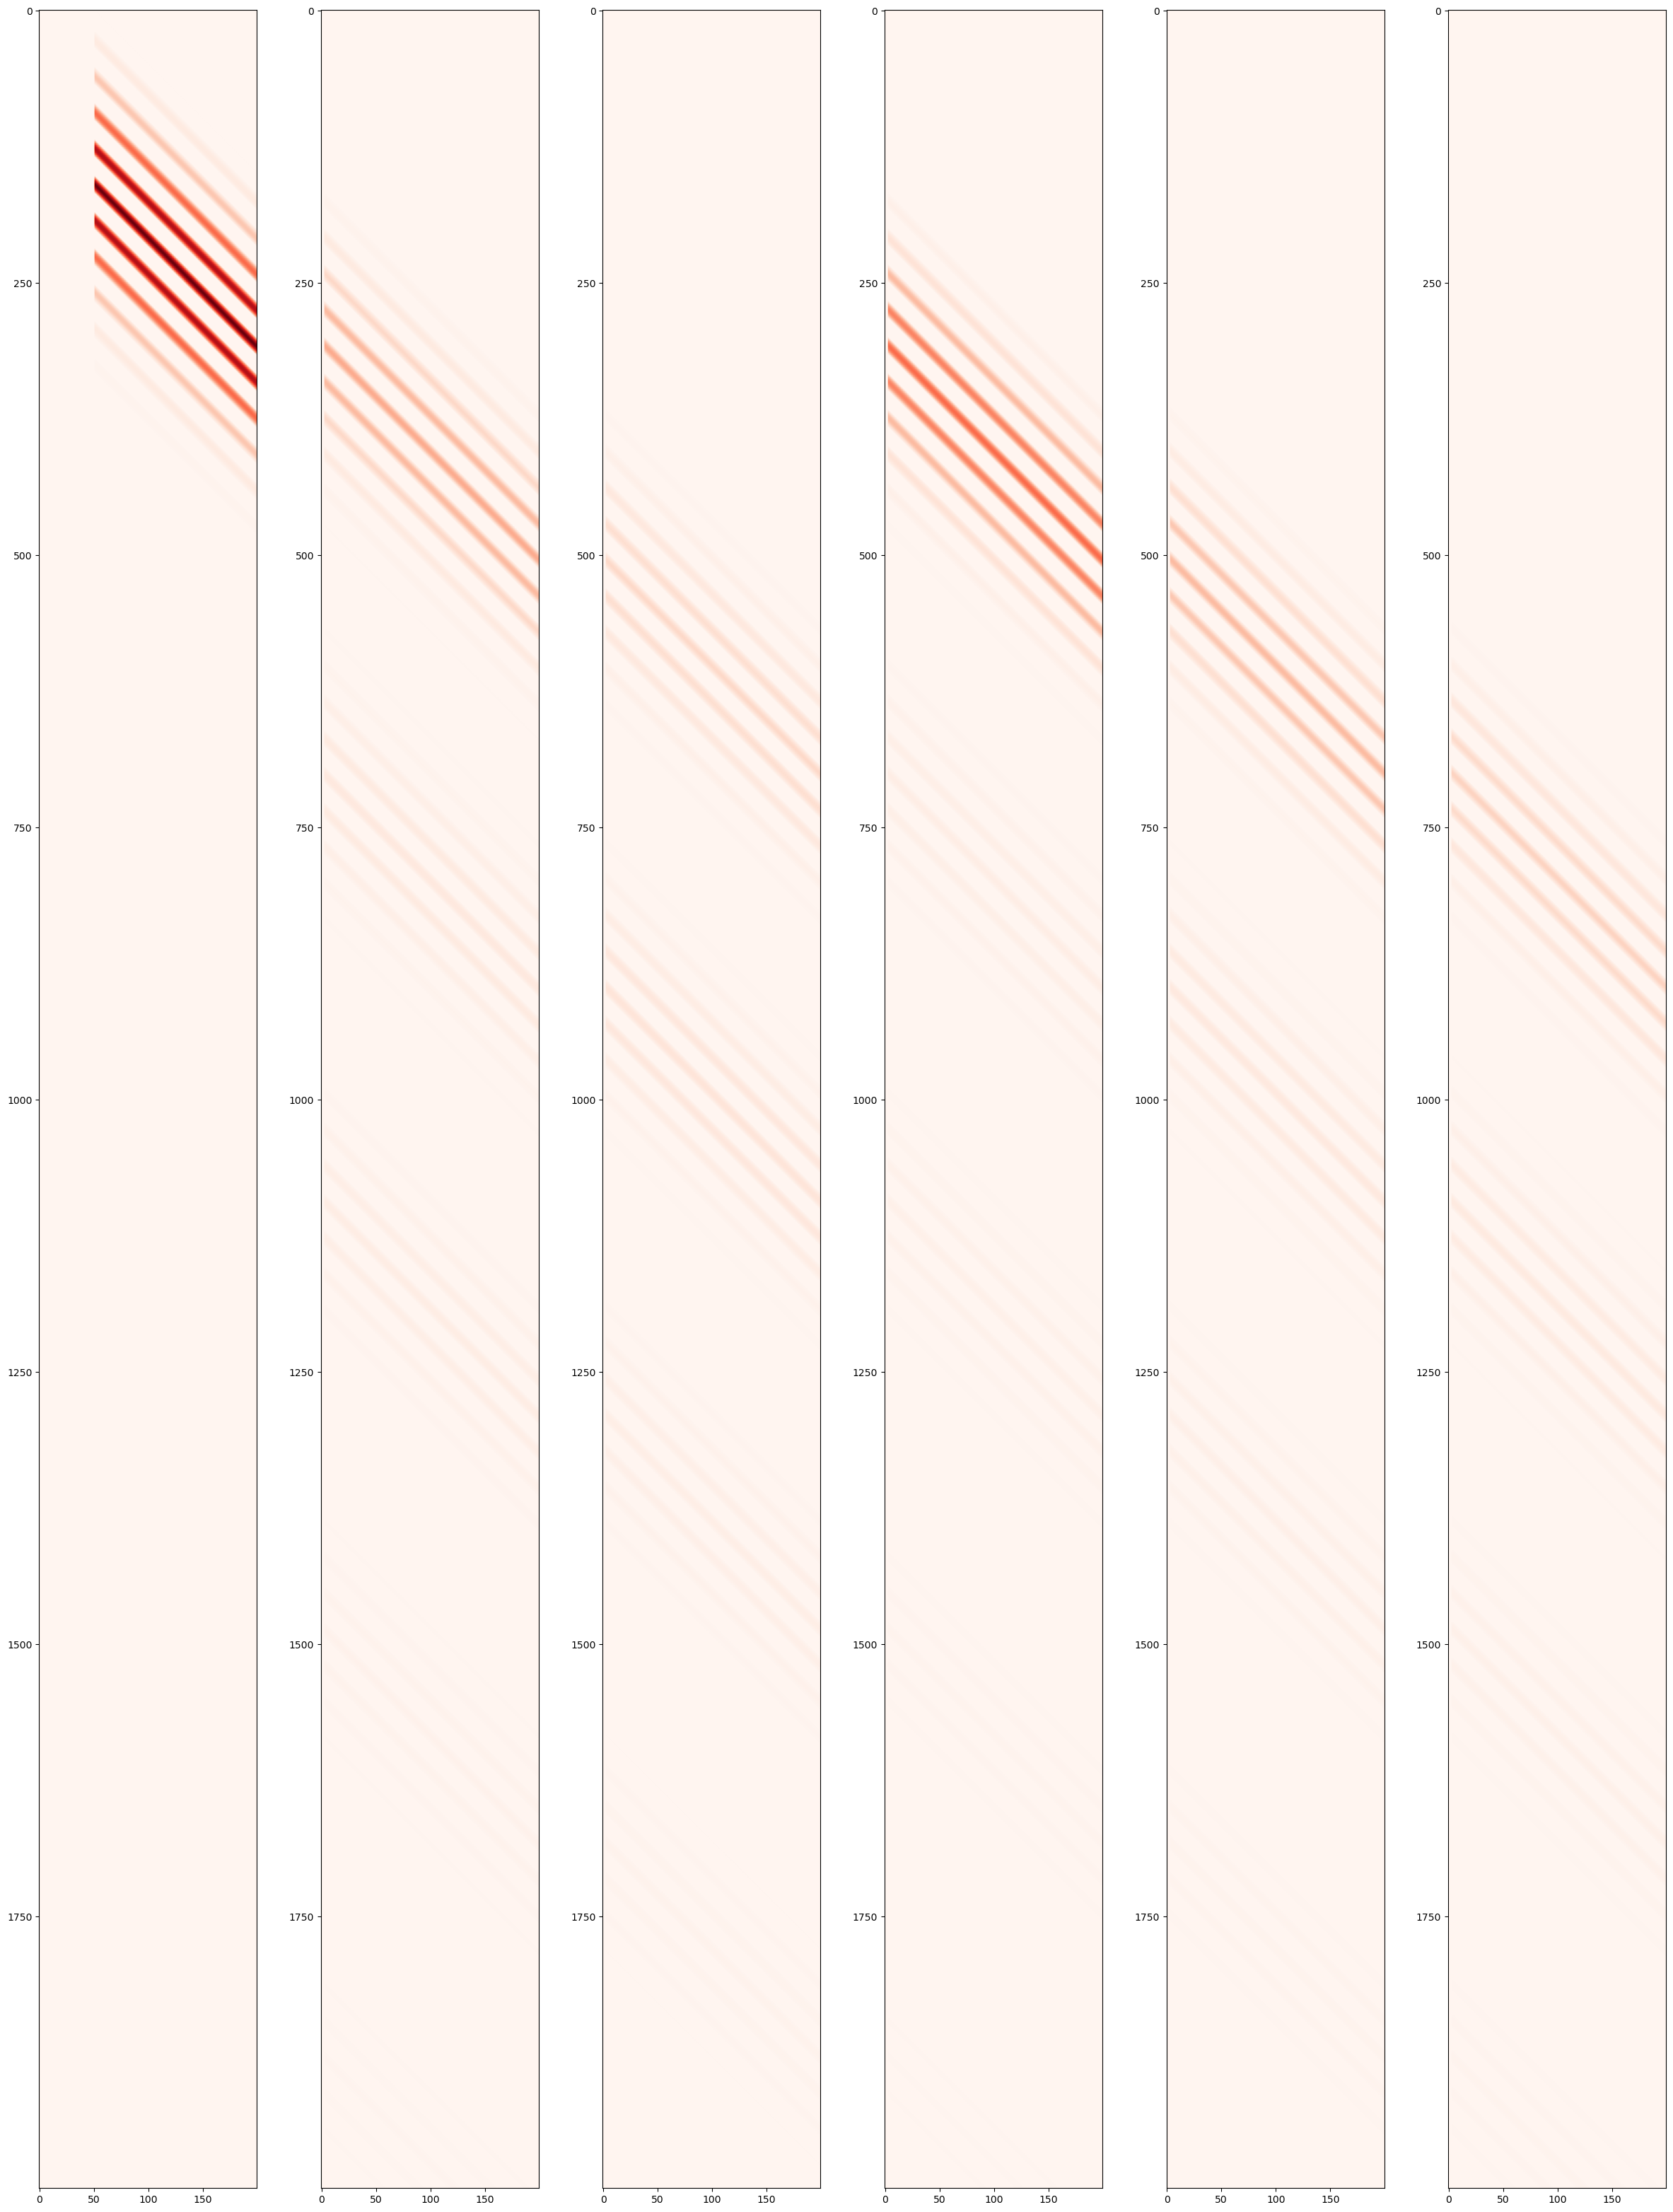

In [291]:
f, ax = plt.subplots(1,6, figsize=(30,40)) 

vmax_val = np.max(ez_tab[0,:,:])

for ii in range(N_seg):
    ax[ii].imshow(ez_tab[ii,:,:], vmin = 0, vmax = vmax_val , cmap = 'Reds')
    # plt.colorbar()
plt.show()

# plt.plot(ez_tab[:,15])

In [292]:
# for ii in range(N_seg):
#     filename = f"ez_tab_{ii:04d}.csv"  # e.g., ez_tab_0000.txt, ez_tab_0001.txt, ...
#     f = open(filename)
#     print(f.readline())

In [293]:
# import csv
# for ii in range(N_seg):
#     filename = f"ez_tab_{ii:04d}.csv"
#     with open(filename) as f:
#         csv_reader = csv.reader(f, delimiter=',')
#         for row in f:
#             print(f.shape)
        
    

range(0, 200)


C:\Users\Mitali\AppData\Local\Temp\ipykernel_18444\3783014481.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


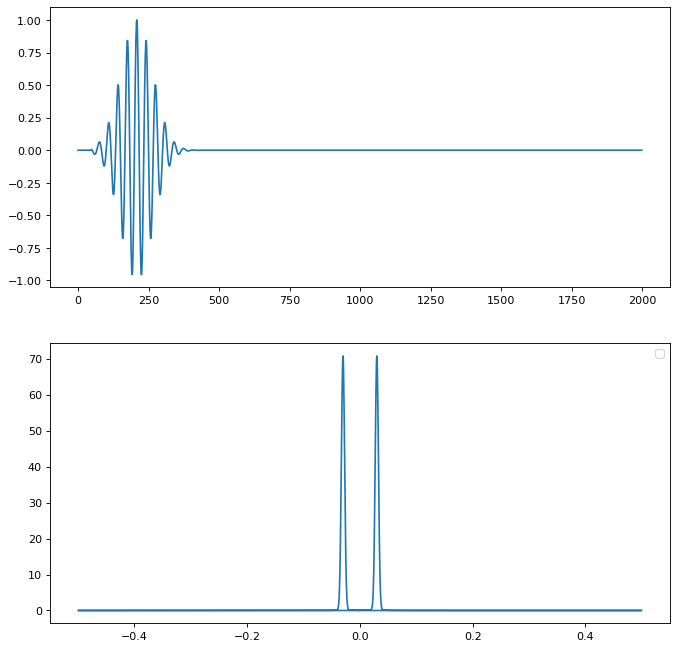

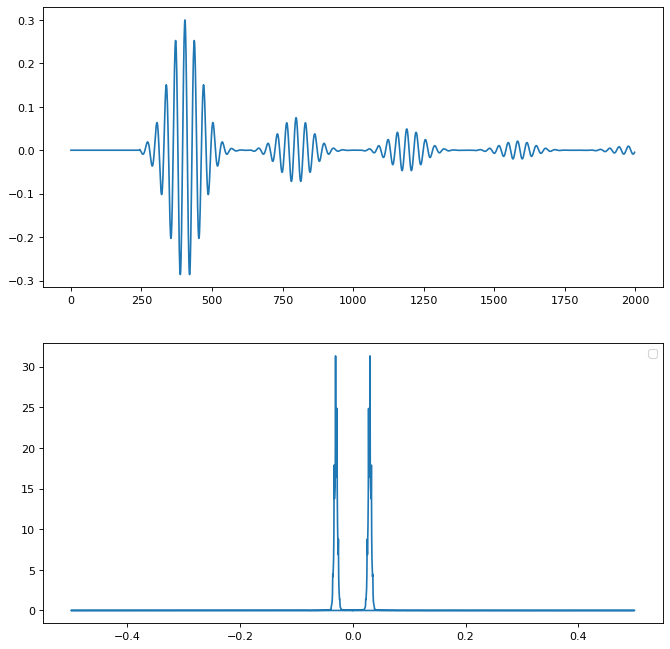

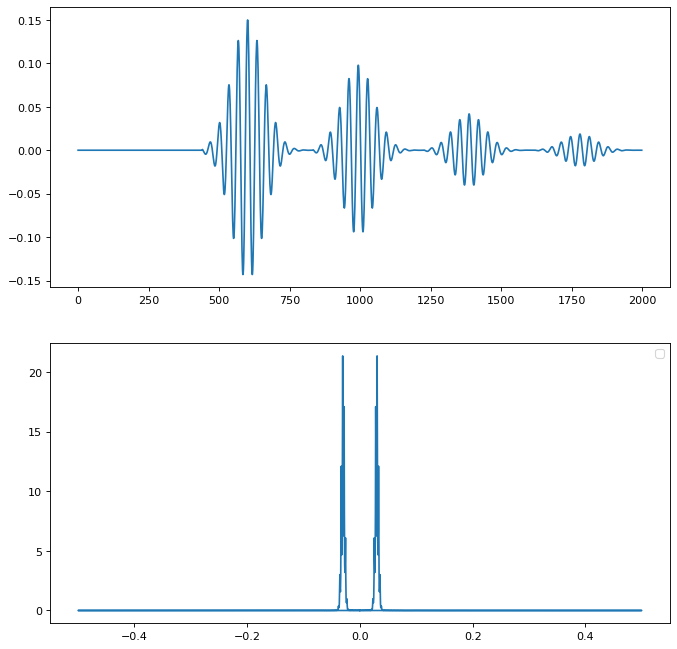

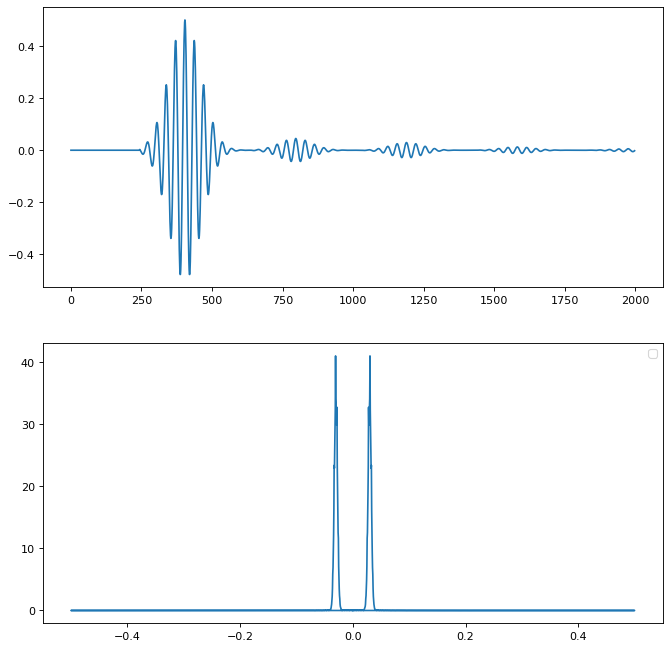

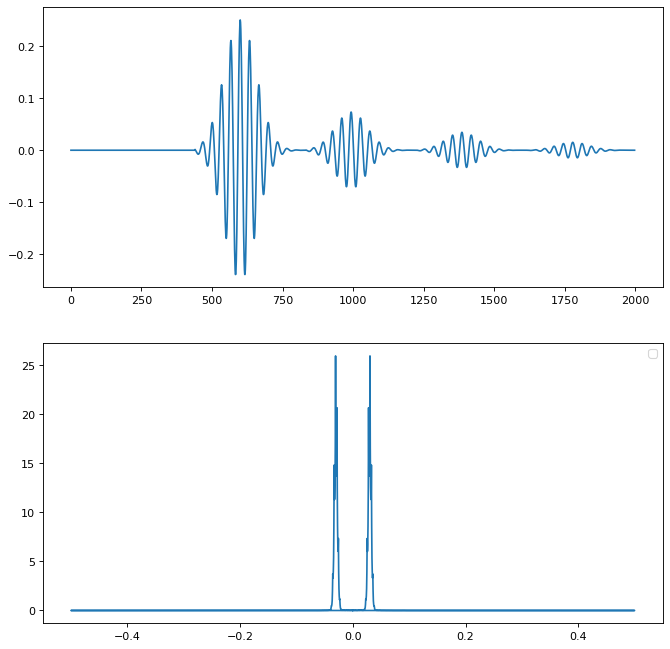

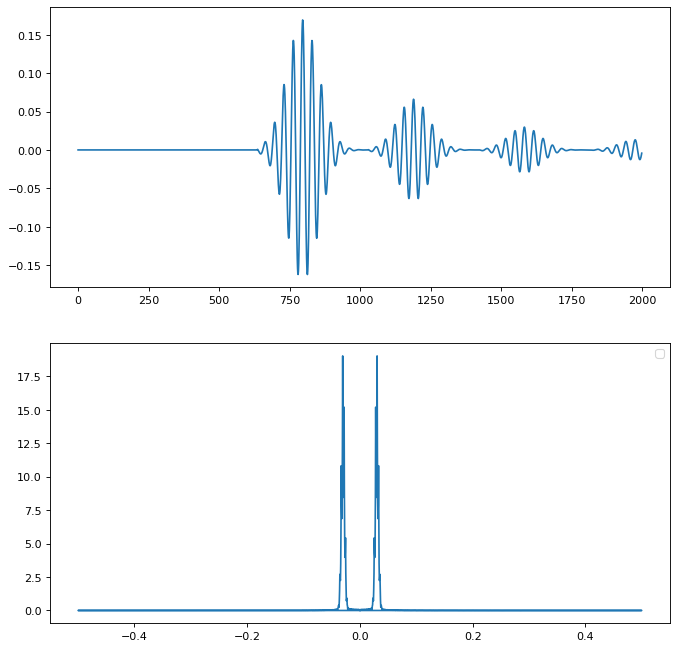

In [298]:
import pandas as pd
Ez = np.zeros((1999,200))
yf = np.zeros((1999,200))
N = 1999
T = 1
xf = fftfreq(N,T)

for ii in range(N_seg):

    filename = f"ez_tab_{ii:04d}.csv"
    df = pd.read_csv(filename)
    # print(df.shape)
    Ez[:,ii] = df.iloc[:,100]
    Ez[:,ii] -= np.mean(Ez[:,ii])
    
    yf[:,ii] = abs(fft(Ez[:,ii]))
    
    #accessing particular columns - all elements(all time steps for a particular spatial coordinate.)
x = range(len(df.iloc[0,:])) 
print(x)   

for ii in range(N_seg):
    figure(figsize=(10, 10), dpi=80)
    plt.subplot(2,1,1)
    plt.plot(Ez[:,ii], label={ii})
    plt.subplot(2,1,2)
    plt.plot(xf,yf[:,ii])
    plt.legend()
    plt.show()


In [295]:
x

range(0, 200)